# Task 2 — Sentiment Analysis & Thematic Categorization (All 3 Banks)

**Objective:**  
Use the cleaned review datasets from Task 1 (`data/processed/CBE.csv`, `data/processed/BOA.csv`, `data/processed/DB.csv`) to:
1. Compute lexicon-based sentiment (TextBlob, VADER).  
2. Extract frequent words (CountVectorizer) and TF-IDF features.  
3. Run topic modeling (LDA) to surface themes.  
4. Extract nouns (spaCy) for keyword analysis.  
5. Save per-bank sentiment + theme results for downstream reporting.

This notebook runs the same pipeline for each bank and produces comparatives for later visualization.


In [2]:
# Cell 2: Import libraries

import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

import spacy
import re
import warnings
sys.path.append("../src/")
from config import DATA_PATHES
warnings.filterwarnings("ignore")

# Make plots prettier and consistent
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


In [3]:
# Cell 3: Download required models/resources (only first time)

# NLTK VADER lexicon for SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# instantiate VADER
sia = SentimentIntensityAnalyzer()

# Ensure spaCy model is available; if not, try to download it.
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    print("spaCy model 'en_core_web_sm' not found — attempting to download.")
    # Try to download via spacy CLI
    import subprocess
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

print("NLP resources ready.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tsegaye/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


NLP resources ready.


In [4]:
# Cell 4: Helper functions

def safe_read_csv(path):
    """Read CSV if exists, return empty DataFrame otherwise."""
    if not Path(path).exists():
        print(f"Warning: {path} not found. Returning empty DataFrame.")
        return pd.DataFrame()
    return pd.read_csv(path)

def preprocess_text(s):
    """
    Basic text cleaning for tokenization/LDA:
    - lowercasing, remove non-alpha (preserve whitespace), collapse spaces
    """
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def textblob_polarity(text):
    """Return TextBlob polarity and subjectivity."""
    try:
        tb = TextBlob(text)
        return tb.sentiment.polarity, tb.sentiment.subjectivity
    except Exception:
        return 0.0, 0.0

def vader_compound(text):
    """Return VADER compound score (float)."""
    try:
        return sia.polarity_scores(text)["compound"]
    except Exception:
        return 0.0

def polarity_to_label(p, pos_thresh=0.1, neg_thresh=-0.1):
    """Convert polarity float to label."""
    if p > pos_thresh:
        return "positive"
    elif p < neg_thresh:
        return "negative"
    else:
        return "neutral"

def vader_label(c, pos_thresh=0.05, neg_thresh=-0.05):
    """Standard VADER thresholds to label sentiment."""
    if c >= pos_thresh:
        return "positive"
    elif c <= neg_thresh:
        return "negative"
    else:
        return "neutral"

def extract_nouns_spacy(text, nlp_pipeline):
    """Return nouns from text using spaCy (simple token text extraction)."""
    try:
        doc = nlp_pipeline(text)
        return [token.text for token in doc if token.pos_ == "NOUN"]
    except Exception:
        return []

def run_lda(tokens_list, num_topics=3, passes=10, random_state=42):
    """
    Run gensim LDA on a list of token lists.
    Returns (lda_model, dictionary, corpus)
    """
    dictionary = Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    if len(dictionary) == 0:
        return None, dictionary, corpus
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        random_state=random_state
    )
    return lda, dictionary, corpus


In [5]:
# Cell 5: Load processed CSVs
processed_dir = DATA_PATHES["processed"]
paths = {
    "CBE": f"{processed_dir}/CBE.csv",
    "BOA": f"{processed_dir}/BOA.csv",
    "DB":  f"{processed_dir}/DB.csv"
}

dfs = {}
for bank, p in paths.items():
    df = safe_read_csv(p)
    if df.empty:
        print(f"Note: {bank} dataframe is empty or missing: {p}")
    # ensure expected columns exist; if not, try to map common alternatives
    # canonical columns we'll use: review, rating, date, app_name, bank_name
    if "review" not in df.columns and "review_text" in df.columns:
        df = df.rename(columns={"review_text": "review"})
    if "rating" not in df.columns and "score" in df.columns:
        df = df.rename(columns={"score": "rating"})
    dfs[bank] = df

# Quick preview counts
for k, df in dfs.items():
    print(f"{k}: rows={len(df)} columns={list(df.columns)}")


CBE: rows=400 columns=['reviewId', 'review', 'rating', 'date', 'app_name', 'bank_name', 'month', 'year']
BOA: rows=400 columns=['reviewId', 'review', 'rating', 'date', 'app_name', 'bank_name', 'month', 'year']
DB: rows=400 columns=['reviewId', 'review', 'rating', 'date', 'app_name', 'bank_name', 'month', 'year']


In [6]:
# Cell 6: Per-bank processing loop
output_sentiment_dir = DATA_PATHES["sentiment_results"]
output_final_dir = DATA_PATHES["final"]
os.makedirs(output_sentiment_dir, exist_ok=True)
os.makedirs(output_final_dir, exist_ok=True)

# Parameters for vectorizers and LDA
top_n_words = 15
lda_topics = 3
lda_passes = 10

summary = {}  # store quick stats per bank

for bank, df in dfs.items():
    print("\n" + "="*60)
    print(f"Processing bank: {bank} (rows={len(df)})")
    if df.empty:
        print(f"Skipping {bank} (no data).")
        continue

    # Ensure review column exists and fill NA safely
    df["review"] = df["review"].fillna("").astype(str)

    # 1) Basic cleaning for downstream text features
    df["clean_text"] = df["review"].apply(preprocess_text)

    # 2) TextBlob sentiment (polarity & subjectivity)
    tb_results = df["review"].apply(textblob_polarity)
    df["tb_polarity"] = [r[0] for r in tb_results]
    df["tb_subjectivity"] = [r[1] for r in tb_results]
    df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

    # 3) VADER sentiment
    df["vader_compound"] = df["review"].apply(vader_compound)
    df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

    # 4) Frequency-based words (CountVectorizer)
    count_vec = CountVectorizer(stop_words="english")
    X_counts = count_vec.fit_transform(df["clean_text"])
    vocab = np.array(count_vec.get_feature_names_out())
    counts = np.asarray(X_counts.sum(axis=0)).flatten()
    freq_df = pd.DataFrame({"word": vocab, "count": counts}).sort_values("count", ascending=False)
    top_words = freq_df.head(top_n_words)

    # 5) TF-IDF
    tfidf_vec = TfidfVectorizer(stop_words="english")
    X_tfidf = tfidf_vec.fit_transform(df["clean_text"])
    tfidf_vocab = np.array(tfidf_vec.get_feature_names_out())
    tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
    tfidf_df = pd.DataFrame({"word": tfidf_vocab, "tfidf": tfidf_means}).sort_values("tfidf", ascending=False)
    top_tfidf = tfidf_df.head(top_n_words)

    # 6) Simple tokenization for LDA & noun extraction
    # Tokenize into words and remove very short tokens
    df["tokens"] = df["clean_text"].apply(lambda t: [w for w in t.split() if len(w) > 2])

    # Optionally remove English stopwords for LDA - simple list
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_stop
    df["tokens_nostop"] = df["tokens"].apply(lambda toks: [w for w in toks if w not in sk_stop])

    # 7) Run LDA
    lda_model, dictionary, corpus = run_lda(df["tokens_nostop"].tolist(), num_topics=lda_topics, passes=lda_passes)
    if lda_model is None:
        print("LDA: insufficient vocabulary, skipping topics.")
        topics = []
    else:
        topics = lda_model.show_topics(num_topics=lda_topics, num_words=8, formatted=False)

    # 8) Extract nouns with spaCy
    df["nouns"] = df["review"].apply(lambda x: extract_nouns_spacy(x, nlp))
    # Get top nouns
    all_nouns = [n for sub in df["nouns"].tolist() for n in sub]
    noun_freq = pd.Series(all_nouns).value_counts().reset_index()
    noun_freq.columns = ["noun", "count"]

    # 9) Save intermediate sentiment results
    sentiment_cols = ["review", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment", "vader_compound", "vader_sentiment"]
    sentiment_df = df[[c for c in sentiment_cols if c in df.columns]].copy()
    sentiment_path = f"{output_sentiment_dir}/{bank}_sentiment.csv"
    sentiment_df.to_csv(sentiment_path, index=False)
    print(f"Saved sentiment file: {sentiment_path} (rows={len(sentiment_df)})")

    # 10) Save final combined dataset (with themes/tokens)
    final_path = f"{output_final_dir}/{bank}_final.csv"
    df.to_csv(final_path, index=False)
    print(f"Saved final file: {final_path} (rows={len(df)})")

    # 11) Summarize results to print
    print("\nTop words (frequency):")
    display(top_words.head(10))

    print("\nTop words (TF-IDF):")
    display(top_tfidf.head(10))

    if topics:
        print("\nLDA topics:")
        for tidx, topic in topics:
            print(f"Topic {tidx}: ", ", ".join([w for w, _ in topic]))
    else:
        print("\nNo LDA topics available.")

    print("\nTop nouns:")
    display(noun_freq.head(10))

    # Save stats for comparison across banks
    summary[bank] = {
        "n_reviews": len(df),
        "top_freq_words": top_words.head(5)["word"].tolist(),
        "top_tfidf_words": top_tfidf.head(5)["word"].tolist(),
        "top_nouns": noun_freq.head(5)["noun"].tolist(),
        "avg_tb_polarity": df["tb_polarity"].mean(),
        "avg_vader_compound": df["vader_compound"].mean()
    }



Processing bank: CBE (rows=400)
Saved sentiment file: ../data/sentiment_results/CBE_sentiment.csv (rows=400)
Saved final file: ../data/final/CBE_final.csv (rows=400)

Top words (frequency):


,word,count
55,app,113
300,good,87
87,bank,29
98,best,29
130,cbe,26
443,nice,25
57,application,17
677,update,17
377,like,17
685,use,14



Top words (TF-IDF):


,word,tfidf
300,good,0.158024
55,app,0.084127
98,best,0.050783
443,nice,0.046199
130,cbe,0.022426
87,bank,0.021310
240,excellent,0.019083
377,like,0.019075
458,ok,0.015584
57,application,0.015332



LDA topics:
Topic 0:  cbe, app, nice, bank, like, pin, update, branch
Topic 1:  good, app, excellent, transaction, money, work, application, apps
Topic 2:  app, best, bank, like, ethiopia, application, great, love

Top nouns:


,noun,count
0,app,100
1,bank,20
2,application,13
3,update,12
4,service,11
5,banking,10
6,money,10
7,time,9
8,account,8
9,user,7



Processing bank: BOA (rows=400)
Saved sentiment file: ../data/sentiment_results/BOA_sentiment.csv (rows=400)
Saved final file: ../data/final/BOA_final.csv (rows=400)

Top words (frequency):


,word,count
55,app,150
331,good,62
82,bank,45
98,best,31
104,boa,29
769,work,25
86,banking,24
476,mobile,24
776,worst,21
698,time,20



Top words (TF-IDF):


,word,tfidf
331,good,0.117964
55,app,0.074992
98,best,0.051116
490,nice,0.029294
104,boa,0.028925
82,bank,0.025326
335,great,0.020593
772,working,0.018952
86,banking,0.018323
776,worst,0.017872



LDA topics:
Topic 0:  app, best, banking, nice, bank, doesn, worst, work
Topic 1:  app, boa, developer, bank, use, working, phone, great
Topic 2:  good, app, bank, time, boa, update, worst, make

Top nouns:


,noun,count
0,app,117
1,bank,34
2,time,20
3,banking,20
4,money,16
5,developer,16
6,phone,14
7,times,12
8,options,12
9,apps,11



Processing bank: DB (rows=400)
Saved sentiment file: ../data/sentiment_results/DB_sentiment.csv (rows=400)
Saved final file: ../data/final/DB_final.csv (rows=400)

Top words (frequency):


,word,count
43,app,183
331,good,61
69,bank,57
169,dashen,44
70,banking,38
87,best,38
676,super,33
756,use,27
490,nice,23
215,easy,20



Top words (TF-IDF):


,word,tfidf
331,good,0.107959
43,app,0.086540
87,best,0.049632
490,nice,0.049466
801,wow,0.033871
69,bank,0.032854
169,dashen,0.028133
676,super,0.025059
38,amazing,0.020760
269,fast,0.020244



LDA topics:
Topic 0:  good, app, banking, amazing, super, like, dashen, design
Topic 1:  app, bank, dashen, nice, best, banking, mobile, use
Topic 2:  app, best, wow, fast, super, excellent, use, working

Top nouns:


,noun,count
0,app,148
1,banking,34
2,bank,30
3,user,14
4,step,11
5,money,10
6,time,10
7,features,9
8,application,9
9,design,9


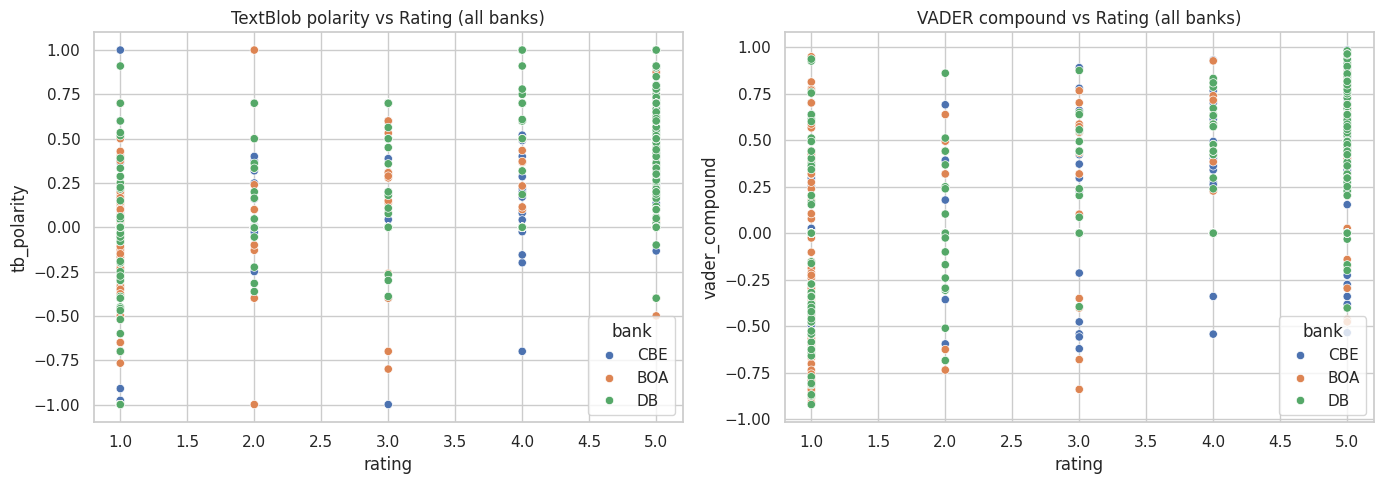

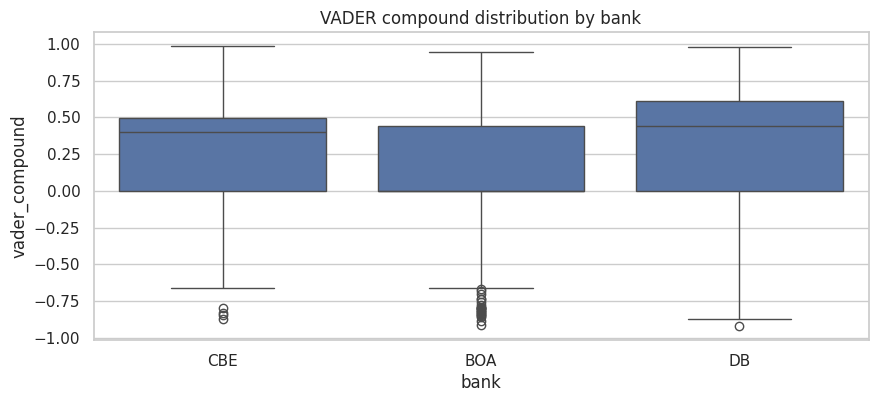

In [7]:
# Cell 7: Comparative scatter plots and distributions across banks

# Build a combined DataFrame with bank label
combined = []
for bank, df in dfs.items():
    if df.empty:
        continue
    tmp = df.copy()
    tmp["bank"] = bank
    combined.append(tmp[["bank", "rating", "tb_polarity", "vader_compound"]].copy())

if combined:
    combined_df = pd.concat(combined, ignore_index=True)
    # Scatter: rating vs TextBlob polarity
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.scatterplot(data=combined_df, x="rating", y="tb_polarity", hue="bank", ax=axes[0])
    axes[0].set_title("TextBlob polarity vs Rating (all banks)")

    sns.scatterplot(data=combined_df, x="rating", y="vader_compound", hue="bank", ax=axes[1])
    axes[1].set_title("VADER compound vs Rating (all banks)")

    plt.tight_layout()
    plt.show()

    # Distribution of VADER sentiments per bank
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=combined_df, x="bank", y="vader_compound")
    plt.title("VADER compound distribution by bank")
    plt.show()
else:
    print("No combined data available for plotting.")


In [10]:
# Cell 8: Print summary and save a quick summary CSV/JSON

import json
summary_df = pd.DataFrame.from_dict(summary, orient="index")
display(summary_df)

# Save summary artifacts
summary_df.to_csv("../data/sentiment_results/summary_across_banks.csv", index=True)
with open("../data/sentiment_results/summary_across_banks.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved summary CSV and JSON to data/sentiment_results/")


,n_reviews,top_freq_words,top_tfidf_words,top_nouns,avg_tb_polarity,avg_vader_compound
CBE,400,"[app, good, bank, best, cbe]","[good, app, best, nice, cbe]","[app, bank, application, update, service]",0.320757,0.263155
BOA,400,"[app, good, bank, best, boa]","[good, app, best, nice, boa]","[app, bank, time, banking, money]",0.212517,0.137309
DB,400,"[app, good, bank, dashen, banking]","[good, app, best, nice, wow]","[app, banking, bank, user, step]",0.315880,0.307399


Saved summary CSV and JSON to data/sentiment_results/


## Notes, limitations & next steps

- **Lexicon methods** (TextBlob, VADER) are fast and interpretable but can miss context-specific sentiment (e.g., sarcasm, domain-specific words).  
- **TF-IDF / LDA** here use a small corpus; with more reviews you will get sharper topics. Consider running LDA with a larger number of passes and more topics.  
- **spaCy noun extraction** is a quick way to collect candidate keywords for theme grouping; consider additional lemmatization and phrase extraction (noun_chunks) later.  
- **Next steps:**  
  - Train / fine-tune a small transformer model or a classifier (e.g., LinearSVC) for bank-domain sentiment.  
  - Build a rule-based theme detector using the LDA + noun lists as seeds.  
  - Aggregate themes into time series to detect recent regressions (e.g., spikes in "login" issues).
